In [1]:
from random import shuffle
import glob
import sys
import cv2
import numpy as np
#import skimage.io as io
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def load_image(addr):
    # read an image and resize to (224, 224)
    img = cv2.imread(addr)
    if img is None:
        return None
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
 
def createDataRecord(out_filename, addrs, labels):
    # open the TFRecords file
    writer = tf.python_io.TFRecordWriter(out_filename)
    for i in range(len(addrs)):
        
        # Load the image
        img = load_image(addrs[i])
        label = labels[i]

        if img is None:
            continue

        # Create a feature
        feature = {
            'image_raw': _bytes_feature(img.tostring()),
            'label': _int64_feature(label)
        }
        
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        
        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
        
    writer.close()
    sys.stdout.flush()


In [3]:

cat_dog_train_path = 'total/*.png'

# read addresses and labels from the 'train' folder
addrs = glob.glob(cat_dog_train_path)
labels = [int((addr.split('_')[0]).split('/')[1]) for addr in addrs] 
len(addrs)


399

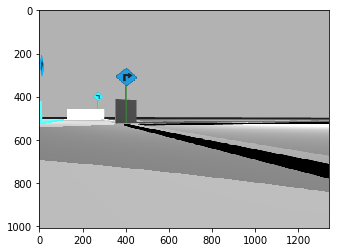

In [4]:
ex = '/home/venkat/Desktop/AI_ML/Hackathon-2/data/total/4_r24.png'
img = cv2.imread(ex,cv2.IMREAD_UNCHANGED)
plt.imshow(img) 

Text(0.5,1,'4')

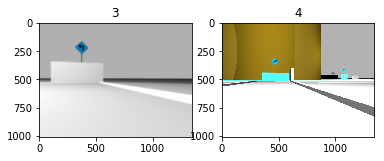

In [5]:

img = cv2.imread(ex)
plt.imshow(img)  
plt.subplot(121)
img = cv2.imread(addrs[0])
plt.imshow(img)   
plt.title(labels[0])
plt.subplot(122)
img = cv2.imread(addrs[1])
plt.imshow(img)   
plt.title(labels[1])

In [6]:
# to shuffle data
c = list(zip(addrs, labels))
shuffle(c)
addrs, labels = zip(*c)


In [8]:


    
# Divide the data into 60% train, 20% validation, and 20% test
train_addrs = addrs[0:int(0.8*len(addrs))]
train_labels = labels[0:int(0.8*len(labels))]
#val_addrs = addrs[int(0.8*len(addrs)):int(0.8*len(addrs))]
#val_labels = labels[int(0.7*len(addrs)):int(0.8*len(addrs))]
test_addrs = addrs[int(0.8*len(addrs)):]
test_labels = labels[int(0.8*len(labels)):]

createDataRecord('train.tfrecords', train_addrs, train_labels)
#createDataRecord('val.tfrecords', val_addrs, val_labels)
createDataRecord('test.tfrecords', test_addrs, test_labels)

In [9]:
logs_path = "logs"
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# op to write logs to Tensorboard
summary_writer = tf.summary.FileWriter(logs_path, graph=sess.graph)

def parser(record):
    keys_to_features = {
        "image_raw": tf.FixedLenFeature([], tf.string),
        "label":     tf.FixedLenFeature([], tf.int64)
    }
    parsed = tf.parse_single_example(record, keys_to_features)
    image = tf.decode_raw(parsed["image_raw"], tf.uint8)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, shape=[224, 224, 3])
    label = tf.cast(parsed["label"], tf.int32)

    return {'image': image}, label


def input_fn(filenames):
    dataset = tf.data.TFRecordDataset(filenames=filenames)
    dataset = dataset.shuffle(buffer_size=64)
    dataset = dataset.map(map_func=parser)
    dataset = dataset.batch(batch_size=64)
    dataset = dataset.prefetch(buffer_size=64)
    return dataset

def train_input_fn():
    #return input_fn(filenames=["train.tfrecords", "test.tfrecords"])
    return input_fn(filenames=["train.tfrecords"])

def val_input_fn():
    return input_fn(filenames=["test.tfrecords"])

def model_fn(features, labels, mode, params):
    num_classes = 6
    net = features["image"]

    net = tf.reshape(net, [-1, 224, 224, 3])   

    net = tf.layers.conv2d(inputs=net, name='layer_conv1',filters=32, kernel_size=3,padding='same', activation=tf.nn.relu)
    
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

    net = tf.layers.conv2d(inputs=net, name='layer_conv2',filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)    

    net = tf.contrib.layers.flatten(net)

    net = tf.layers.dense(inputs=net, name='layer_fc1', units=128, activation=tf.nn.relu)    
    net = tf.layers.dense(inputs=net, name='layer_fc_2', units=num_classes)

    logits = net
    y_pred = tf.nn.softmax(logits=logits)
    y_pred_cls = tf.argmax(y_pred, axis=1)

    if mode == tf.estimator.ModeKeys.PREDICT:
        spec = tf.estimator.EstimatorSpec(mode=mode,predictions=y_pred_cls)
    else:
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=logits)
        loss = tf.reduce_mean(cross_entropy)
        tf.summary.scalar('loss', loss)

        optimizer = tf.train.AdamOptimizer(learning_rate=params["learning_rate"])
        
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        metrics = { "accuracy": tf.metrics.accuracy(labels, y_pred_cls)}
        #tf.summary.scalar("accuracy", tf.metrics.accuracy(labels, y_pred_cls))
        
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
    return spec

model = tf.estimator.Estimator(model_fn=model_fn,
                               params={"learning_rate": 1e-4},
                               model_dir="./model2/")

count = 0
while (count < 10):
    model.train(input_fn=train_input_fn, steps=None)
    
    result = model.evaluate(input_fn=val_input_fn)
    print(result)
    print("Classification accuracy: {0:.2%}".format(result["accuracy"]))
    sys.stdout.flush()
    count = count + 1

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_task_type': 'worker', '_save_summary_steps': 100, '_tf_random_seed': None, '_session_config': None, '_keep_checkpoint_max': 5, '_master': '', '_evaluation_master': '', '_num_worker_replicas': 1, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f90ebc61be0>, '_save_checkpoints_steps': None, '_num_ps_replicas': 0, '_save_checkpoints_secs': 600, '_global_id_in_cluster': 0, '_train_distribute': None, '_model_dir': './model2/', '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model2/model.ckpt-723
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 724 i

INFO:tensorflow:Saving dict for global step 758: accuracy = 0.8375, global_step = 758, loss = 0.35769176
{'accuracy': 0.8375, 'global_step': 758, 'loss': 0.35769176}
Classification accuracy: 83.75%
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model2/model.ckpt-758
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 759 into ./model2/model.ckpt.
INFO:tensorflow:step = 759, loss = 0.26013604
INFO:tensorflow:Saving checkpoints for 763 into ./model2/model.ckpt.
INFO:tensorflow:Loss for final step: 0.42988545.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-16-11:04:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model2/model.ckpt-763
INFO:tensorflow:Running local_i

In [10]:
result = model.evaluate(input_fn=val_input_fn)
result

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-16-11:08:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model2/model.ckpt-773
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-16-11:08:25
INFO:tensorflow:Saving dict for global step 773: accuracy = 0.8875, global_step = 773, loss = 0.2578984


{'accuracy': 0.8875, 'global_step': 773, 'loss': 0.2578984}

In [18]:
testData = val_input_fn()
testData[0]
#resu = model.predict(input_fn=val_input_fn)
#for i in resu:
#    print(i)

TypeError: 'PrefetchDataset' object does not support indexing

In [29]:
for test in test_addrs:
    model.predict()


TypeError: 'Iterator' object is not iterable